In [1]:
## Studnet ID: 20759072

## quesetion a

from tensorflow.keras import layers, Model, Sequential
from tensorflow import keras
import tensorflow
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.layers import GaussianNoise

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train = np.expand_dims(x_train, axis=-1)
x_train = tensorflow.image.resize(x_train, [32,32])

x_test = np.expand_dims(x_test, axis=-1)
x_test = tensorflow.image.resize(x_test, [32,32])

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

x_train_slice = x_train[:6000]
y_train_slice= y_train[:6000]


## First define the model

vgg_model = Sequential()

##Feautre layer

vgg_model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding='same',input_shape = (32, 32, 1)))
vgg_model.add(MaxPooling2D(pool_size=(2, 2)))

vgg_model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
vgg_model.add(MaxPooling2D(pool_size=(2, 2)))

vgg_model.add(Conv2D(256, (3, 3), activation='relu',padding='same'))

vgg_model.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
vgg_model.add(MaxPooling2D(pool_size=(2, 2)))

vgg_model.add(Conv2D(512, (3, 3), activation='relu',padding='same'))

vgg_model.add(Conv2D(512, (3, 3), activation='relu',padding='same'))
vgg_model.add(MaxPooling2D(pool_size=(2, 2)))

vgg_model.add(Conv2D(512, (3, 3), activation='relu',padding='same'))

vgg_model.add(Conv2D(512, (3, 3), activation='relu',padding='same'))
vgg_model.add(MaxPooling2D(pool_size=(2, 2)))


# FC Layers

vgg_model.add(Flatten())

vgg_model.add(Dense(4096, activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(4096, activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(10, activation='softmax'))

# print(model.summary())

vgg_model.compile(loss=keras.losses.categorical_crossentropy , optimizer=keras.optimizers.Adam(lr=0.00001), metrics=['accuracy'])




/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [2]:
## question a

## Simulate the epoch using different size of minibatch
training_loss = []
training_accuracy = []
test_loss = []
test_accuracy = []


history = vgg_model.fit(x_train, y_train, batch_size=512, epochs=5, verbose=1, validation_data=(x_test, y_test), steps_per_epoch=60000/512)
score = vgg_model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])





Epoch 1/5
117/117 [==============================] - 15s 89ms/step - loss: 2.1580 - accuracy: 0.2139 - val_loss: 1.5197 - val_accuracy: 0.4899
Epoch 2/5
117/117 [==============================] - 8s 72ms/step - loss: 1.0757 - accuracy: 0.6111 - val_loss: 0.6542 - val_accuracy: 0.7841
Epoch 3/5
117/117 [==============================] - 8s 70ms/step - loss: 0.5894 - accuracy: 0.7987 - val_loss: 0.4193 - val_accuracy: 0.8669
Epoch 4/5
117/117 [==============================] - 8s 72ms/step - loss: 0.4033 - accuracy: 0.8705 - val_loss: 0.2910 - val_accuracy: 0.9089
Epoch 5/5
117/117 [==============================] - 8s 69ms/step - loss: 0.2857 - accuracy: 0.9123 - val_loss: 0.2039 - val_accuracy: 0.9376
Test loss: 0.2038903385400772
Test accuracy: 0.9376000165939331


In [3]:
## Question b


import tensorflow as tf

def generate_image_adversary(model, image, label, eps):
	# cast the image
  image = tf.cast(image, tf.float32)

  with tf.GradientTape() as tape:
    # explicitly indicate that our image should be tacked for
    # gradient updates
    tape.watch(image)
    # use our model to make predictions on the input image and
    # then compute the loss
    pred = model(image)
    loss = keras.losses.categorical_crossentropy(label, pred)

  # calculate the gradients of loss with respect to the image, then
  # compute the sign of the gradient
  gradient = tape.gradient(loss, image)
  signedGrad = tf.sign(gradient)
  # construct the image adversary
  adversary = (image + (signedGrad * eps)).numpy()
  # return the image adversary to the calling function
  return adversary


episilon_value = 0.2



ad_x_test = generate_image_adversary(vgg_model, x_test, y_test, episilon_value)



In [4]:
score = vgg_model.evaluate(ad_x_test, y_test, verbose=0)
print("Epsilon: 0.2")
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epsilon: 0.2
Test loss: 6.415348052978516
Test accuracy: 0.044599998742341995


FGSM attack image with epsilon 0.2


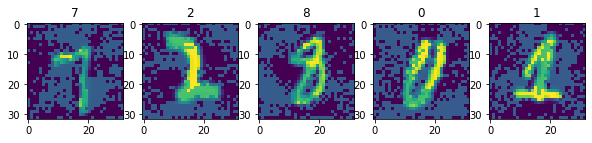

In [5]:
import matplotlib.pyplot as plt
import random
random_list = random.sample(range(1, 6000), 5)
fig = plt.figure(figsize=(10, 7))

print("FGSM attack image with epsilon 0.2")

for i in range(5):
  fig.add_subplot(1, 5, i+1)
  
  trial = ad_x_test[random_list[i]].reshape(32,32)

  # showing image
  plt.imshow(trial)
  plt.title(np.argmax(y_test[random_list[i]]))

In [6]:
episilon_value = 0.1


ad_x_test_1 = generate_image_adversary(vgg_model, x_test, y_test, episilon_value)

score = vgg_model.evaluate(ad_x_test_1, y_test, verbose=0)
print("Epsilon: 0.1")
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epsilon: 0.1
Test loss: 2.229656457901001
Test accuracy: 0.3652999997138977


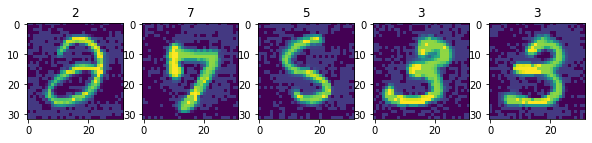

In [7]:
import matplotlib.pyplot as plt
import random
random_list = random.sample(range(1, 6000), 5)
fig = plt.figure(figsize=(10, 7))


for i in range(5):
  fig.add_subplot(1, 5, i+1)
  
  trial = ad_x_test_1[random_list[i]].reshape(32,32)

  # showing image
  plt.imshow(trial)
  plt.title(np.argmax(y_test[random_list[i]]))

In [8]:
episilon_value = 0.5


ad_x_test_5 = generate_image_adversary(vgg_model, x_test, y_test, episilon_value)

score = vgg_model.evaluate(ad_x_test_5, y_test, verbose=0)
print("Epsilon: 0.5")
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epsilon: 0.5
Test loss: 16.48651123046875
Test accuracy: 0.004999999888241291


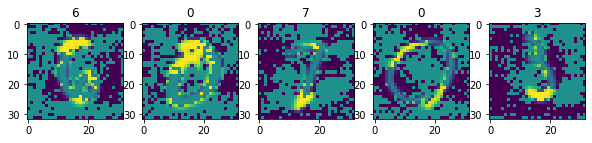

In [9]:
import matplotlib.pyplot as plt
import random
random_list = random.sample(range(1, 6000), 5)
fig = plt.figure(figsize=(10, 7))


for i in range(5):
  fig.add_subplot(1, 5, i+1)
  
  trial = ad_x_test_5[random_list[i]].reshape(32,32)

  # showing image
  plt.imshow(trial)
  plt.title(np.argmax(y_test[random_list[i]]))

In [10]:
## quesetion c

from tensorflow.keras import layers, Model, Sequential
from tensorflow import keras
import tensorflow
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.layers import GaussianNoise

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train = np.expand_dims(x_train, axis=-1)
x_train = tensorflow.image.resize(x_train, [32,32])

x_test = np.expand_dims(x_test, axis=-1)
x_test = tensorflow.image.resize(x_test, [32,32])

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

x_train_slice = x_train[:6000]
y_train_slice= y_train[:6000]


## First define the model

model = Sequential()

##Feautre layer

model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding='same',input_shape = (32, 32, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu',padding='same'))

model.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu',padding='same'))

model.add(Conv2D(512, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu',padding='same'))

model.add(Conv2D(512, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))


# FC Layers

model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# print(model.summary())

# model.compile(loss=keras.losses.categorical_crossentropy , optimizer=keras.optimizers.Adam(lr=0.00001), metrics=['accuracy'])




In [11]:
pip install neural_structured_learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import neural_structured_learning as nsl

# model.compile(loss=keras.losses.categorical_crossentropy , optimizer=keras.optimizers.Adam(lr=0.00001), metrics=['accuracy'])


adv_config = nsl.configs.make_adv_reg_config(
    multiplier=0.2,
    adv_step_size=0.2,
    adv_grad_norm='infinity'
)

adv_model_2 = nsl.keras.AdversarialRegularization(
    model,
    label_keys=['label'],
    adv_config=adv_config
)
# model.summary()
adv_model_2.compile(loss=keras.losses.categorical_crossentropy , optimizer=keras.optimizers.Adam(lr=0.00001), metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
opt = tf.keras.optimizers.Adam(learning_rate=1.0e-4)

adv_model_2.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

adv_model_2.fit(x={'feature': x_train, 'label': y_train}, batch_size=42, epochs=1)

# res = adv_model.predict(x={'feature': x_test, 'label': y_test})

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


   1/1429 [..............................] - ETA: 8:08:30 - loss: 2.7640 - categorical_crossentropy: 2.3033 - categorical_accuracy: 0.1667 - scaled_adversarial_loss: 0.4607WARNING: AutoGraph could not transform <function wrap at 0x7fcb69b48f80> and will run it as-is.
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1429/1429 [==============================] - 82s 43ms/step - loss: 0.4133 - categorical_crossentropy: 0.2460 - categorical_accuracy: 0.9161 - scaled_adversarial_loss: 0.1673


In [14]:
print("Unattack Test")

res = adv_model_2.evaluate(x={'feature': x_test, 'label': y_test})

Unattack Test
313/313 [==============================] - 6s 17ms/step - loss: 0.1452 - categorical_crossentropy: 0.0506 - categorical_accuracy: 0.9838 - scaled_adversarial_loss: 0.0947


In [15]:
score =  adv_model_2.evaluate(x={'feature': ad_x_test, 'label': y_test})
print("Epsilon: 0.2")
print("Test loss:", score[0])
print("Test accuracy:", score[1])

313/313 [==============================] - 6s 18ms/step - loss: 4.6942 - categorical_crossentropy: 2.1813 - categorical_accuracy: 0.3814 - scaled_adversarial_loss: 2.5129
Epsilon: 0.2
Test loss: 4.694221019744873
Test accuracy: 2.181316614151001


In [16]:
score =  adv_model_2.evaluate(x={'feature': ad_x_test_1, 'label': y_test})
print("Epsilon: 0.1")
print("Test loss:", score[0])
print("Test accuracy:", score[1])

313/313 [==============================] - 5s 17ms/step - loss: 1.7163 - categorical_crossentropy: 0.4363 - categorical_accuracy: 0.8573 - scaled_adversarial_loss: 1.2800
Epsilon: 0.1
Test loss: 1.7163037061691284
Test accuracy: 0.4363267719745636


In [17]:
score =  adv_model_2.evaluate(x={'feature': ad_x_test_5, 'label': y_test})
print("Epsilon: 0.5")
print("Test loss:", score[0])
print("Test accuracy:", score[1])

313/313 [==============================] - 5s 17ms/step - loss: 16.2655 - categorical_crossentropy: 10.7705 - categorical_accuracy: 0.0197 - scaled_adversarial_loss: 5.4951
Epsilon: 0.5
Test loss: 16.265514373779297
Test accuracy: 10.770455360412598


In [18]:
## quesetion d

from tensorflow.keras import layers, Model, Sequential
from tensorflow import keras
import tensorflow
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.layers import GaussianNoise

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train = np.expand_dims(x_train, axis=-1)
x_train = tensorflow.image.resize(x_train, [32,32])

x_test = np.expand_dims(x_test, axis=-1)
x_test = tensorflow.image.resize(x_test, [32,32])

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

x_train_slice = x_train[:6000]
y_train_slice= y_train[:6000]


## First define the model

model = Sequential()

##Feautre layer

model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding='same',input_shape = (32, 32, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu',padding='same'))

model.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu',padding='same'))

model.add(Conv2D(512, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu',padding='same'))

model.add(Conv2D(512, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))


# FC Layers

model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# print(model.summary())

# model.compile(loss=keras.losses.categorical_crossentropy , optimizer=keras.optimizers.Adam(lr=0.00001), metrics=['accuracy'])




In [19]:




import neural_structured_learning as nsl

# model.compile(loss=keras.losses.categorical_crossentropy , optimizer=keras.optimizers.Adam(lr=0.00001), metrics=['accuracy'])


adv_config_pgd = nsl.configs.make_adv_reg_config(
    multiplier=0.2,
    adv_step_size=0.2,
    adv_grad_norm='infinity',
    pgd_iterations=50,
    pgd_epsilon=0.2,
    clip_value_min = 0,
    clip_value_max = 1
)

adv_model_pgd = nsl.keras.AdversarialRegularization(
    model,
    # label_keys=['label'],
    adv_config=adv_config_pgd
)
# model.summary()
# adv_model_pgd.compile(loss=keras.losses.categorical_crossentropy , optimizer=keras.optimizers.Adam(lr=0.00001), metrics=['accuracy'])



In [20]:
opt = tf.keras.optimizers.Adam(learning_rate=1.0e-4)

adv_model_pgd.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

adv_model_pgd.fit(x={'feature': x_train, 'label': y_train}, batch_size=42, epochs=1)

# res = adv_model_pgd.predict(x={'feature': x_test, 'label': y_test})

1429/1429 [==============================] - 672s 454ms/step - loss: 0.5675 - categorical_crossentropy: 0.2446 - categorical_accuracy: 0.9179 - scaled_adversarial_loss: 0.3229


In [21]:
print("PGD model with standard test")
score = adv_model_pgd.evaluate(x={'feature': x_test, 'label': y_test})
print("Test loss:", score[0])
print("Test accuracy:", score[2])

PGD model with standard test
313/313 [==============================] - 130s 381ms/step - loss: 0.2504 - categorical_crossentropy: 0.0444 - categorical_accuracy: 0.9862 - scaled_adversarial_loss: 0.2059
Test loss: 0.2503626048564911
Test accuracy: 0.9861999750137329


In [22]:
print("PGD model with FGSM. test with 0.2 epsilon")
score = adv_model_pgd.evaluate(x={'feature': ad_x_test, 'label': y_test})
print("Test loss:", score[0])
print("Test accuracy:", score[2])

PGD model with FGSM. test with 0.2 epsilon
313/313 [==============================] - 119s 381ms/step - loss: 1.3243 - categorical_crossentropy: 0.4476 - categorical_accuracy: 0.8822 - scaled_adversarial_loss: 0.8767
Test loss: 1.3242617845535278
Test accuracy: 0.8822000026702881


In [23]:
print("PGD model with FGSM. test with 0.1 epsilon")
score = adv_model_pgd.evaluate(x={'feature': ad_x_test_1, 'label': y_test})
print("Test loss:", score[0])
print("Test accuracy:", score[2])

PGD model with FGSM. test with 0.1 epsilon
313/313 [==============================] - 119s 381ms/step - loss: 0.6666 - categorical_crossentropy: 0.2065 - categorical_accuracy: 0.9578 - scaled_adversarial_loss: 0.4601
Test loss: 0.6665821075439453
Test accuracy: 0.9577999711036682


In [24]:
print("PGD model with FGSM. test with 0.5 epsilon")
score = adv_model_pgd.evaluate(x={'feature': ad_x_test_5, 'label': y_test})
print("Test loss:", score[0])
print("Test accuracy:", score[2])

PGD model with FGSM. test with 0.5 epsilon
313/313 [==============================] - 120s 382ms/step - loss: 5.0226 - categorical_crossentropy: 3.3533 - categorical_accuracy: 0.0706 - scaled_adversarial_loss: 1.6693
Test loss: 5.022578716278076
Test accuracy: 0.0706000030040741


In [25]:
## question d 
import neural_structured_learning as nsl
import tensorflow as tf


episilon_value = 0.1

# image = tf.cast(x_train, tf.float32)
pred = vgg_model(x_test)
loss = keras.losses.categorical_crossentropy(y_test, pred)

with tf.GradientTape() as tape:
  tape.watch(x_train)


adv_config = nsl.configs.AdvNeighborConfig(
    feature_mask=None,
    adv_step_size=0.02,
    adv_grad_norm="infinity",
    clip_value_min=0,
    clip_value_max=1,
    pgd_iterations=50,
    pgd_epsilon=episilon_value
)

adv_attack_1_pgd = nsl.lib.gen_adv_neighbor(x_test,labeled_loss=loss,config=adv_config,raise_invalid_gradient=False, pgd_model_fn=vgg_model, gradient_tape=tape, pgd_loss_fn=keras.losses.categorical_crossentropy,pgd_labels=y_test)


In [26]:
# print(adv_attack_1_pgd[0][random_list[i]])

PGD attack image with epsilon 0.1


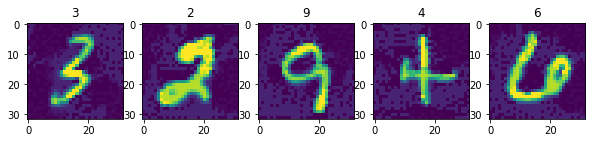

In [27]:
import matplotlib.pyplot as plt
import random
random_list = random.sample(range(1, 6000), 5)
fig = plt.figure(figsize=(10, 7))

print("PGD attack image with epsilon 0.1")
for i in range(5):
  fig.add_subplot(1, 5, i+1)
  
  trial = adv_attack_1_pgd[0][random_list[i]]

  # showing image
  plt.imshow(trial[:,:,0])
  plt.title(np.argmax(y_test[random_list[i]]))

In [28]:
# print(len(x_test))



score = adv_model_pgd.evaluate(x={'feature': adv_attack_1_pgd[0], 'label': y_test})
print("PGD model with PGD test with 0.1 epsilon")

print("Epsilon: 0.1")
print("Test loss:", score[0])
print("Test accuracy:", score[2])

313/313 [==============================] - 119s 381ms/step - loss: 0.5829 - categorical_crossentropy: 0.1165 - categorical_accuracy: 0.9650 - scaled_adversarial_loss: 0.4664
PGD model with PGD test with 0.1 epsilon
Epsilon: 0.1
Test loss: 0.5828976631164551
Test accuracy: 0.9649999737739563


In [29]:
## question d 
import neural_structured_learning as nsl
import tensorflow as tf


episilon_value = 0.2

# image = tf.cast(x_train, tf.float32)
pred = vgg_model(x_test)
loss = keras.losses.categorical_crossentropy(y_test, pred)

with tf.GradientTape() as tape:
  tape.watch(x_train)


adv_config = nsl.configs.AdvNeighborConfig(
    feature_mask=None,
    adv_step_size=0.02,
    adv_grad_norm="infinity",
    clip_value_min=0,
    clip_value_max=1,
    pgd_iterations=50,
    pgd_epsilon=episilon_value
)

adv_attack_2_pgd = nsl.lib.gen_adv_neighbor(x_test,labeled_loss=loss,config=adv_config,raise_invalid_gradient=False, pgd_model_fn=vgg_model, gradient_tape=tape, pgd_loss_fn=keras.losses.categorical_crossentropy,pgd_labels=y_test)


PGD attack image with epsilon 0.2


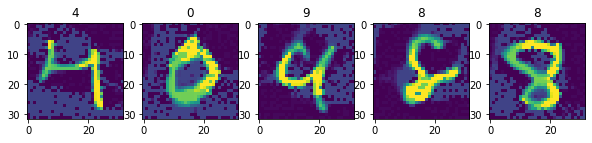

In [30]:
import matplotlib.pyplot as plt
import random
random_list = random.sample(range(1, 6000), 5)
fig = plt.figure(figsize=(10, 7))

print("PGD attack image with epsilon 0.2")

for i in range(5):
  fig.add_subplot(1, 5, i+1)
  
  trial = adv_attack_2_pgd[0][random_list[i]]

  # showing image
  plt.imshow(trial[:,:,0])
  plt.title(np.argmax(y_test[random_list[i]]))

In [31]:
# print(len(x_test))



score = adv_model_pgd.evaluate(x={'feature': adv_attack_2_pgd[0], 'label': y_test})
print("PGD model with PGD test with 0.2 epsilon")

print("Epsilon: 0.2")
print("Test loss:", score[0])
print("Test accuracy:", score[2])

313/313 [==============================] - 119s 381ms/step - loss: 1.2785 - categorical_crossentropy: 0.3857 - categorical_accuracy: 0.8870 - scaled_adversarial_loss: 0.8928
PGD model with PGD test with 0.2 epsilon
Epsilon: 0.2
Test loss: 1.2785420417785645
Test accuracy: 0.8870000243186951


In [32]:
## question d 
import neural_structured_learning as nsl
import tensorflow as tf


episilon_value = 0.5

# image = tf.cast(x_train, tf.float32)
pred = vgg_model(x_test)
loss = keras.losses.categorical_crossentropy(y_test, pred)

with tf.GradientTape() as tape:
  tape.watch(x_train)


adv_config = nsl.configs.AdvNeighborConfig(
    feature_mask=None,
    adv_step_size=0.02,
    adv_grad_norm="infinity",
    clip_value_min=0,
    clip_value_max=1,
    pgd_iterations=50,
    pgd_epsilon=episilon_value
)

adv_attack_5_pgd = nsl.lib.gen_adv_neighbor(x_test,labeled_loss=loss,config=adv_config,raise_invalid_gradient=False, pgd_model_fn=vgg_model, gradient_tape=tape, pgd_loss_fn=keras.losses.categorical_crossentropy,pgd_labels=y_test)


PGD attack image with epsilon 0.5


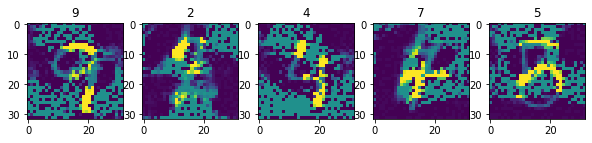

In [33]:
import matplotlib.pyplot as plt
import random
random_list = random.sample(range(1, 6000), 5)
fig = plt.figure(figsize=(10, 7))

print("PGD attack image with epsilon 0.5")

for i in range(5):
  fig.add_subplot(1, 5, i+1)
  
  trial = adv_attack_5_pgd[0][random_list[i]]

  # showing image
  plt.imshow(trial[:,:,0])
  plt.title(np.argmax(y_test[random_list[i]]))

In [34]:
# print(len(x_test))



score = adv_model_pgd.evaluate(x={'feature': adv_attack_5_pgd[0], 'label': y_test})
print("PGD model with PGD test with 0.5 epsilon")

print("Epsilon: 0.5")
print("Test loss:", score[0])
print("Test accuracy:", score[2])

313/313 [==============================] - 119s 381ms/step - loss: 6.0335 - categorical_crossentropy: 4.3093 - categorical_accuracy: 0.0087 - scaled_adversarial_loss: 1.7242
PGD model with PGD test with 0.5 epsilon
Epsilon: 0.5
Test loss: 6.03345251083374
Test accuracy: 0.008700000122189522


In [35]:
# print(len(x_test))


score = vgg_model.evaluate(adv_attack_1_pgd[0], y_test, verbose=0)

print("VGG model with PGD test with 0.1 epsilon")

print("Epsilon: 0.1")
print("Test loss:", score[0])
print("Test accuracy:", score[1])

VGG model with PGD test with 0.1 epsilon
Epsilon: 0.1
Test loss: 2.2083096504211426
Test accuracy: 0.34130001068115234


In [36]:
# print(len(x_test))

score = vgg_model.evaluate(adv_attack_2_pgd[0], y_test, verbose=0)


print("VGG model with PGD test with 0.2 epsilon")

print("Epsilon: 0.2")
print("Test loss:", score[0])
print("Test accuracy:", score[1])

VGG model with PGD test with 0.2 epsilon
Epsilon: 0.2
Test loss: 7.314349174499512
Test accuracy: 0.005400000140070915


In [37]:
# print(len(x_test))


score = vgg_model.evaluate(adv_attack_5_pgd[0], y_test, verbose=0)

print("VGG model with PGD test with 0.5 epsilon")

print("Epsilon: 0.5")
print("Test loss:", score[0])
print("Test accuracy:", score[1])

VGG model with PGD test with 0.5 epsilon
Epsilon: 0.5
Test loss: 18.523096084594727
Test accuracy: 0.0


In [38]:
score =  adv_model_2.evaluate(x={'feature': adv_attack_1_pgd[0], 'label': y_test})

print("0.2 epsilon FGSM model with PGD test with 0.1 epsilon")

print("Epsilon: 0.1")
print("Test loss:", score[0])
print("Test accuracy:", score[2])

313/313 [==============================] - 4s 14ms/step - loss: 0.9140 - categorical_crossentropy: 0.2646 - categorical_accuracy: 0.9162 - scaled_adversarial_loss: 0.6494
0.2 epsilon FGSM model with PGD test with 0.1 epsilon
Epsilon: 0.1
Test loss: 0.9140178561210632
Test accuracy: 0.9161999821662903


In [39]:
score =  adv_model_2.evaluate(x={'feature': adv_attack_2_pgd[0], 'label': y_test})

print("0.2 FGSM model with PGD test with 0.2 epsilon")

print("Epsilon: 0.2")
print("Test loss:", score[0])
print("Test accuracy:", score[2])

313/313 [==============================] - 4s 14ms/step - loss: 2.0172 - categorical_crossentropy: 1.1993 - categorical_accuracy: 0.5977 - scaled_adversarial_loss: 0.8179
0.2 FGSM model with PGD test with 0.2 epsilon
Epsilon: 0.2
Test loss: 2.017171859741211
Test accuracy: 0.5976999998092651


In [40]:
score =  adv_model_2.evaluate(x={'feature': adv_attack_5_pgd[0], 'label': y_test})

print("0.2 FGSM model with PGD test with 0.5 epsilon")

print("Epsilon: 0.5")
print("Test loss:", score[0])
print("Test accuracy:", score[2])

313/313 [==============================] - 5s 14ms/step - loss: 5.5056 - categorical_crossentropy: 3.9904 - categorical_accuracy: 0.0436 - scaled_adversarial_loss: 1.5152
0.2 FGSM model with PGD test with 0.5 epsilon
Epsilon: 0.5
Test loss: 5.505611896514893
Test accuracy: 0.04360000044107437
